<a href="https://colab.research.google.com/github/Soedirman-Machine-Learning/rice-quality-classification/blob/master/klasifikasi_kualitas_beras_vgg16_satujenis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!apt-get install subversion > /dev/null
!svn export https://github.com/Soedirman-Machine-Learning/rice-quality-classification/trunk/dataset_n > /dev/null

In [6]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import math, os, sys
import itertools
import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

In [7]:
!ls dataset_n
!ls dataset_n/train
!ls dataset_n/train/ir64/premium
!ls dataset_n/train/ir64/medium
!ls dataset_n/train/ir64/tidak_layak

test  train
ir64
pi_001.jpg  pi_015.jpg	pi_029.jpg  pi_043.jpg	pi_057.jpg  pi_071.jpg
pi_002.jpg  pi_016.jpg	pi_030.jpg  pi_044.jpg	pi_058.jpg  pi_072.jpg
pi_003.jpg  pi_017.jpg	pi_031.jpg  pi_045.jpg	pi_059.jpg  pi_073.jpg
pi_004.jpg  pi_018.jpg	pi_032.jpg  pi_046.jpg	pi_060.jpg  pi_074.jpg
pi_005.jpg  pi_019.jpg	pi_033.jpg  pi_047.jpg	pi_061.jpg  pi_075.jpg
pi_006.jpg  pi_020.jpg	pi_034.jpg  pi_048.jpg	pi_062.jpg  pi_076.jpg
pi_007.jpg  pi_021.jpg	pi_035.jpg  pi_049.jpg	pi_063.jpg  pi_077.jpg
pi_008.jpg  pi_022.jpg	pi_036.jpg  pi_050.jpg	pi_064.jpg  pi_078.jpg
pi_009.jpg  pi_023.jpg	pi_037.jpg  pi_051.jpg	pi_065.jpg  pi_079.jpg
pi_010.jpg  pi_024.jpg	pi_038.jpg  pi_052.jpg	pi_066.jpg  pi_080.jpg
pi_011.jpg  pi_025.jpg	pi_039.jpg  pi_053.jpg	pi_067.jpg
pi_012.jpg  pi_026.jpg	pi_040.jpg  pi_054.jpg	pi_068.jpg
pi_013.jpg  pi_027.jpg	pi_041.jpg  pi_055.jpg	pi_069.jpg
pi_014.jpg  pi_028.jpg	pi_042.jpg  pi_056.jpg	pi_070.jpg
mi_001.jpg  mi_015.jpg	mi_029.jpg  mi_043.jpg	mi_057.jpg  mi_071.

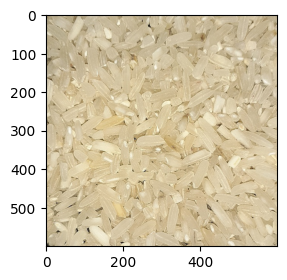

In [8]:
image = imread("dataset_n/train/ir64/medium/mi_014.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [9]:
#pelatihan
image_size =224
Batch_size =128
base_dir =os.path.join('dataset_n/train/ir64')
data_gen= tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=0.2)
train_gen =data_gen.flow_from_directory(
    base_dir, 
    target_size=(image_size, image_size),
    batch_size=Batch_size,
    subset='training')
val_gen = data_gen.flow_from_directory(
    base_dir, 
    target_size=(image_size, image_size),
    batch_size=Batch_size,
    subset='validation')

#pengujian
x_test = []
y_test = []
labels = ['medium', 'premium', 'tidak_layak']

for i, label in enumerate(labels):
  folder =os.path.join("dataset_n/test/ir64",label)
  files =sorted(os.listdir(folder))
  files =[x for x in files if x.endswith(".jpg")]
  for k,file in enumerate(files):
    image_path =os.path.join(folder, file)
    image = imread(image_path)/255.
    image = resize(image,(244,244))
    x_test.append(image)
    category =os.path.split(folder)[-1]
    y_test.append(i)

x_test = np.array(x_test)
y_test = np.array(y_test)
for image_batch, label_batch in train_gen:
  break
print("Bentuk array dari dataset pelatihan adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_gen:
  break
print("Bentuk array dari dataset validasi adalah:", image_batch.shape,label_batch.shape)
print("Bentuk array dari dataset test pengujian adalah:", x_test.shape,y_test.shape)

Found 192 images belonging to 3 classes.
Found 48 images belonging to 3 classes.
Bentuk array dari dataset pelatihan adalah: (128, 224, 224, 3) (128, 3)
Bentuk array dari dataset validasi adalah: (48, 224, 224, 3) (48, 3)
Bentuk array dari dataset test pengujian adalah: (60, 244, 244, 3) (60,)


In [10]:
print (train_gen.class_indices)

labels_txt = '\n'.join(sorted(train_gen.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels_txt)
!cat labels.txt

{'medium': 0, 'premium': 1, 'tidak_layak': 2}
medium
premium
tidak_layak

In [11]:
img_shape = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model VGG-16Net
base_model = tf.keras.applications.VGG16(input_shape=img_shape,
                                              include_top=False, 
                                              weights='imagenet')
base_model.trainable = False
base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [12]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

y_test2 = to_categorical(y_test)
x_test3, y_test3 = (x_test, y_test2)

model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          147488    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 14,862,275
Trainable params: 147,587
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
#pelatihan
initial_epochs = 100
history = model.fit_generator(train_gen, 
                    epochs=initial_epochs, 
                    validation_data=val_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
2/2 [==============================] - 11s 6s/step - loss: 1.1980 - acc: 0.3594 - val_loss: 1.0821 - val_acc: 0.3333
Epoch 2/100
2/2 [==============================] - 1s 613ms/step - loss: 1.1038 - acc: 0.2812 - val_loss: 0.8961 - val_acc: 0.6042
Epoch 3/100
2/2 [==============================] - 1s 608ms/step - loss: 0.9392 - acc: 0.5365 - val_loss: 0.7383 - val_acc: 0.9167
Epoch 4/100
2/2 [==============================] - 1s 603ms/step - loss: 0.7708 - acc: 0.8698 - val_loss: 0.6479 - val_acc: 0.8958
Epoch 5/100
2/2 [==============================] - 2s 1s/step - loss: 0.6940 - acc: 0.8438 - val_loss: 0.5473 - val_acc: 0.9792
Epoch 6/100
2/2 [==============================] - 1s 610ms/step - loss: 0.6054 - acc: 0.9271 - val_loss: 0.4546 - val_acc: 0.9792
Epoch 7/100
2/2 [==============================] - 2s 1s/step - loss: 0.5265 - acc: 0.9323 - val_loss: 0.4021 - val_acc: 0.9375
Epoch 8/100
2/2

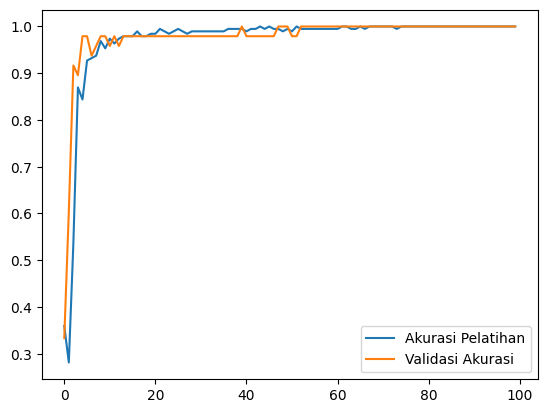

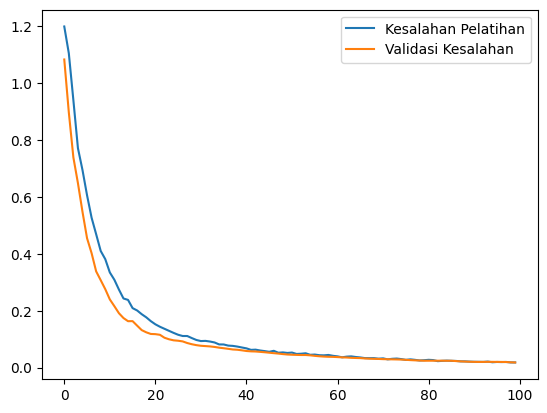

In [14]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

In [15]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))
print(train_gen)

Number of trainable variables = 4


In [16]:
#Prediksi Label Validasi dengan Pelatihan
n = 14
input_image = image_batch[n][np.newaxis,...]
print("Labelnya adalah: ", label_batch[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [1. 0. 0.]
Prediksinya adalah [0.96970403 0.02715182 0.0031442 ]


In [17]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data test
print(model.evaluate(x= x_test3, y= y_test3))

['loss', 'acc']
2/2 [==============================] - 4s 2s/step - loss: 0.2196 - acc: 0.9000
[0.21956326067447662, 0.8999999761581421]


In [18]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1
 0 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


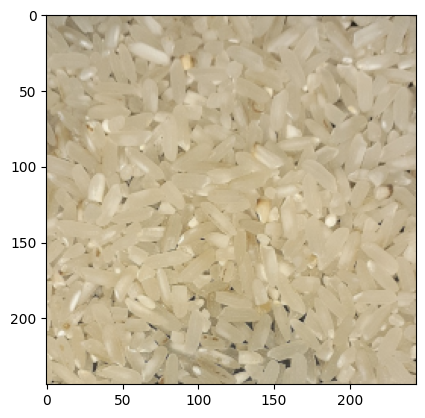

Label yang benar adalah: 0 : medium
Nilai yang diprediksi adalah: [9.9958295e-01 1.8286728e-04 2.3416623e-04]
Label yang diprediksi adalah: 0 : medium
Prediksi benar


In [19]:
n = 14 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")

Normalized confusion matrix
[[1.  0.  0. ]
 [0.3 0.7 0. ]
 [0.  0.  1. ]]


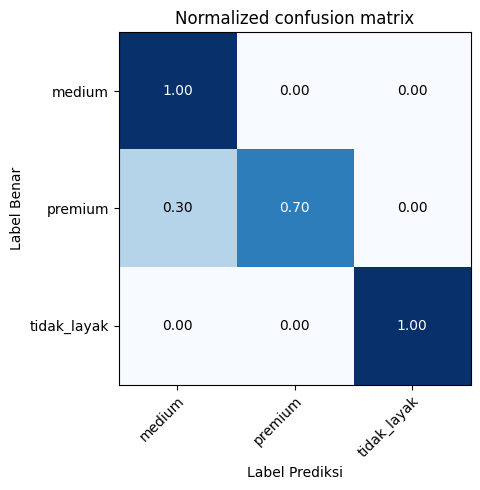

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=labels, normalize=True,
                      title='Normalized confusion matrix')

In [21]:
saved_model_dir = 'save/model'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('Klasifikasi_Kualitas_Beras_VGG16Net_nf.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/model/assets
